
Nineth exercice: non-Cartesian MR image reconstruction
=============================================
In this tutorial we will reconstruct an MRI image from radial undersampled kspace measurements. Let us denote $\Omega$ the undersampling mask, the under-sampled Fourier transform now reads $F_{\Omega}$.

Import neuroimaging data
--------------------------------------
We use the toy datasets available in pysap, more specifically a 2D brain slice and the radial under-sampling scheme. We compare zero-order image reconstruction with Compressed sensing reconstructions (analysis vs synthesis formulation) using the FISTA algorithm for the synthesis formulation and the Condat-Vu algorithm for the analysis formulation.

We remind that the synthesis formulation reads (minimization in the sparsifying domain):
$$
\widehat{z} = \text{arg}\,\min_{z\in C^n_\Psi} \frac{1}{2} \|y - F_\Omega  \Psi^*z \|_2^2 + \lambda \|z\|_1
$$
and the image solution is given by $\widehat{x} = \Psi^*\widehat{z}$. For an orthonormal wavelet transform, 
we have $n_\Psi=n$ while for a frame we may have $n_\Psi > n$.

while the analysis formulation consists in minimizing the following cost function (min. in the image domain):
$$
\widehat{x} = \text{arg}\,\min_{x\in C^n} \frac{1}{2} \|y - F_\Omega x\|_2^2 + \lambda \|\Psi x\|_1 \,.
$$

- Author: Chaithya G R & Philippe Ciuciu
- Date: 01/06/2021 
- Target: ATSI MSc students, Paris-Saclay University

In [9]:
# Package import
#from mri.numerics.fourier import NFFT
#from mri.numerics.reconstruct import sparse_rec_fista
#from mri.numerics.utils import generate_operators
#from mri.numerics.utils import convert_locations_to_mask
#from mri.parallel_mri.extract_sensitivity_maps import \
#    gridded_inverse_fourier_transform_nd
from mri.operators import NonCartesianFFT, WaveletN, WaveletUD2
from mri.operators.utils import convert_locations_to_mask, \
    gridded_inverse_fourier_transform_nd
from mri.reconstructors import SingleChannelReconstructor
import pysap
from pysap.data import get_sample_data

# Third party import
from modopt.math.metrics import ssim
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold
import numpy as np
import matplotlib.pyplot as plt

Loading input data
---------------------------

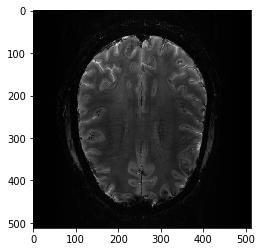

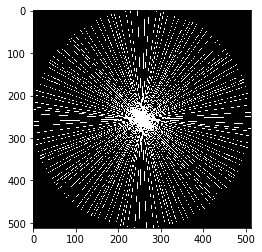

In [16]:
image = get_sample_data('2d-mri')
radial_mask = get_sample_data("mri-radial-samples")
kspace_loc = radial_mask.data
mask = pysap.Image(data=convert_locations_to_mask(kspace_loc, image.shape))
plt.figure()
plt.imshow(image, cmap='gray')
plt.figure()
plt.imshow(mask, cmap='gray')
plt.show()

Generate the kspace
-------------------

From the 2D brain slice and the acquisition mask, we retrospectively
undersample the k-space using a cartesian acquisition mask
We then reconstruct the zero order solution as a baseline

Get the locations of the kspace samples

In [7]:
#fourier_op = NFFT(samples=kspace_loc, shape=image.shape)
#kspace_obs = fourier_op.op(image.data)
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=image.shape,
                             implementation='cpu')
kspace_obs = fourier_op.op(image.data)

NameError: name 'pynfft' is not defined

Gridded solution

In [ ]:
grid_space = np.linspace(-0.5, 0.5, num=image.shape[0])
grid2D = np.meshgrid(grid_space, grid_space)
grid_soln = gridded_inverse_fourier_transform_nd(kspace_loc, kspace_obs,
                                                 tuple(grid2D), 'linear')
plt.imshow(np.abs(grid_soln), cmap='gray')
# Calculate SSIM
base_ssim = ssim(grid_soln, image)
plt.title('Gridded Solution\nSSIM = ' + str(base_ssim))
plt.show()

FISTA optimization
------------------

We now want to refine the zero order solution using a FISTA optimization.
The cost function is set to Proximity Cost + Gradient Cost

In [11]:
linear_op = WaveletN(wavelet_name="sym8", nb_scales=4)
regularizer_op = SparseThreshold(Identity(), 6 * 1e-7, thresh_type="soft")

# Generate operators

In [12]:
reconstructor = SingleChannelReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='synthesis',
    verbose=1,
)

NameError: name 'fourier_op' is not defined

Synthesis formulation: FISTA optimization
------------------------------------------------------------

We now want to refine the zero order solution using a FISTA optimization.
The cost function is set to Proximity Cost + Gradient Cost

In [ ]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='fista',
    num_iterations=200,
)
image_rec = pysap.Image(data=np.abs(x_final))
recon_ssim = ssim(image_rec, image)
plt.imshow(np.abs(image_rec), cmap='gray')
recon_ssim = ssim(image_rec, image)
plt.title('FISTA Reconstruction\nSSIM = ' + str(recon_ssim))
plt.show()

Analysis formulation: Condat-Vu reconstruction 
---------------------------------------------------------------------

In [14]:
linear_op = WaveletUD2(
    wavelet_id=24,
    nb_scale=4,
)

In [15]:
reconstructor = SingleChannelReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='analysis',
    verbose=1,
)

NameError: name 'fourier_op' is not defined

In [ ]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='condatvu',
    num_iterations=200,
)
image_rec = pysap.Image(data=np.abs(x_final))
plt.imshow(np.abs(image_rec), cmap='gray')
recon_ssim = ssim(image_rec, image)
plt.title('Condat-Vu Reconstruction\nSSIM = ' + str(recon_ssim))
plt.show()
